## A short introduction to accessing the DC1 data on NERSC as a collection of individual catalogs and images using LSST DM software
Michael Wood-Vasey

In [48]:
from lsst.afw.table import SourceCatalog, SchemaMapper
from lsst.afw.image import Calib
from lsst.afw.image.utils import CalibNoThrow
import lsst.daf.persistence as dafPersist

In [13]:
file_repo = '/global/cscratch1/sd/desc/DC1/DC1-imsim/full_focalplane_undithered/'

In brief, this repo contains
 * calexp    - calibrated images
 * src       - catalogs
 * deepCoadd - Coadded iamges

These happen to be stored as subdirectories in the repo dir
But the LSST DM pipeline would access them through the butler
by specifying the datasetType

In [14]:
# Get a butler connection to the data repository
butler = dafPersist.Butler(file_repo)

# Get the subset of all data in datasetType='src'
thisSubset = butler.subset(datasetType='src')

# Extract the dataIds from the subset.
dataIds = [dr.dataId for dr in thisSubset]
print(dataIds[0:10])

[{'filter': 'r', 'raft': '4,2', 'sensor': '1,2', 'visit': 1218371}, {'filter': 'r', 'raft': '1,4', 'sensor': '2,2', 'visit': 1218371}, {'filter': 'r', 'raft': '1,2', 'sensor': '0,2', 'visit': 1218371}, {'filter': 'r', 'raft': '1,0', 'sensor': '2,2', 'visit': 1218371}, {'filter': 'r', 'raft': '3,4', 'sensor': '0,1', 'visit': 1218371}, {'filter': 'r', 'raft': '1,4', 'sensor': '0,2', 'visit': 1218371}, {'filter': 'r', 'raft': '3,3', 'sensor': '2,2', 'visit': 1218371}, {'filter': 'r', 'raft': '4,1', 'sensor': '0,2', 'visit': 1218371}, {'filter': 'r', 'raft': '1,3', 'sensor': '1,2', 'visit': 1218371}, {'filter': 'r', 'raft': '1,0', 'sensor': '2,1', 'visit': 1218371}]


In [28]:
# Get one specific by dataId
#  I got this from the list of `dataIds` above
thisDataId = {'filter': 'r', 'raft': '3,3', 'sensor': '0,0', 'visit': 1419441}
src_cat = butler.get(datasetType='src', dataId=thisDataId)
image = butler.get(datasetType='calexp', dataId=thisDataId)
# You can also get only the metadata from the calexp.  
# This is useful, e.g., because the calibration information is associated with the expsoure, 
# not the catalog
calexpMetadata = butler.get(datasetType='calexp_md', dataId=thisDataId)
calib = Calib(calexpMetadata)

You next will naturally want to ask
1. What is in this source catalog?
2. How do I look at an image?

In [29]:
print(src_cat)

<lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x2acbc274b7e0> >


In [30]:
cat.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psfCandidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psfUsed", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psfReserved", doc="Flag set if the source was selected as a PSF candidate, but was reserved from the PSF fitting."),

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

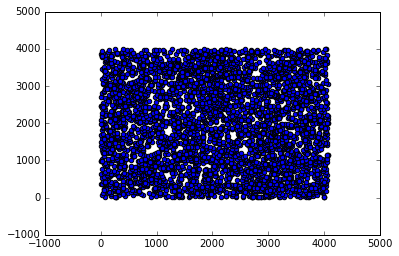

In [32]:
plt.scatter(src_cat['base_SdssCentroid_x'], src_cat['base_SdssCentroid_y'])

(10, 1000000)

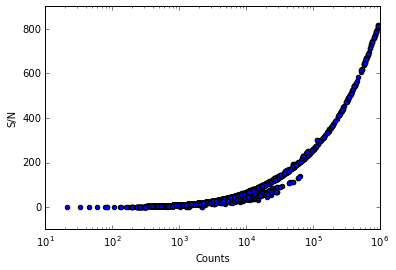

In [44]:
plt.scatter(src_cat['base_PsfFlux_flux'], src_cat['base_PsfFlux_flux']/src_cat['base_PsfFlux_fluxSigma'])
plt.xlabel("Counts")
plt.ylabel("S/N")
plt.xscale('log')
plt.xlim(10, 10**6)

We can get calibrated magnitudes by using the calibration object available from our metadata that we read in for the calexp.

In [49]:
calib = Calib(calexpMetadata)
with CalibNoThrow():
    _ = calib.getMagnitude(src_cat['base_PsfFlux_flux'],
                           src_cat['base_PsfFlux_fluxSigma'])
    mag = _[0]
    mag_err = _[1]

(0, 1)

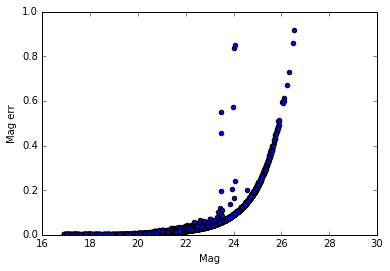

In [52]:
plt.scatter(mag, mag_err)
plt.xlabel("Mag")
plt.ylabel("Mag err")
plt.ylim(0, 1)

### Appendix

For more details, see the following convenient description of products,
input/output from Hsin-Fang Chiang:
 https://confluence.lsstcorp.org/display/~hchiang2/Notes+on+existing+pipeline+components

I paste in the content here because that page requires log-in
but there's noting intended to be private here.

"""
Notes on existing pipeline components

    Created by Hsin-Fang Chiang, last modified on Dec 06, 2016

Some input/output data are conditional and depend on config.

The Butler dataset type names are used. Their policy is in daf_butlerUtils (i.e. obs_base) policy/datasets.yaml and policy/exposures.yaml, or in the specific obs package's mapper paf.

Italic is used to indicate non-traditional datasets (not simple files).

Outputted task metadata is not listed.

To avoid race, the schemas should be outputs of a task's pre-run (with no data) and inputs of its actual run (with data).
1. processCcd.py

There are three main subtasks in ProcessCcdTask.

Processing unit:  CCD

IsrTask

Input: "raw", "bias", "dark", "flat", "defects", "fringes", "brighterFatterKernel", "linearizer"


Output: "postISRCCD"

CharacterizeImageTask

Input: "postISRCCD", "background", "expIdInfo", reference catalog (through "cal_ref_cat" and "refObjLoader", a subtask LoadIndexedReferenceObjectsTask somewhere in the Task spatial lookup  is done to butler-get the shards)

Output: "icExp", "icSrc", "icSrc_schema", "icExpBackground",

CalibrateTask

Input: "icExp", "icExpBackground", "icSrc", "icSrc_schema", "expIdInfo", reference catalog

Output: "calexp", "src", "src_schema", "srcMatch", "calexpBackground"
2. makeSkyMap.py

output: "deep(config.coaddName)Coadd_skyMap" (a pickle file)

Alternatively, use input "calexp",  rather than config, to specify the sky region (makeDiscreteSkyMap.py)
3. makeCoaddTempExp.py

Including selecting exposures to coadd. Inheriting CoaddBaseTask.

input: "calexp", "calexpBackground", "deepCoadd_skyMap", "ccdExposureId"

output: "deepCoadd_tempExp" (one output exposure for each visit::ccd x patch combination)
4. assembleCoadd.py

Including selecting exposures to coadd. Inheriting CoaddBaseTask.

input: "calexp", "calexpBackground", "deepCoadd_skyMap", "deepCoadd_tempExp"

output: "deepCoadd" (one output exposure for each patch+filter)
5. detectCoaddSources.py (DetectCoaddSourcesTask)

input: "deepCoadd"

output: "deepCoadd_det", "deepCoadd_det_schema", "deepCoadd_calexp", "deepCoadd_calexp_background"

Processing unit: tract, patch, filter
6. mergeCoaddDetections.py (MergeDetectionsTask)

input: "deepCoadd_skyMap", "deepCoadd_det", "deepCoadd_det_schema"

output: "deepCoadd_mergeDet", "deepCoadd_mergeDet_schema", "deepCoadd_peak_schema"

Processing unit: tract, patch
7. measureCoaddSources.py (MeasureMergedCoaddSourcesTask)

input:  "deepCoadd_skyMap", "deepCoadd_peak_schema", "deepCoadd_mergeDet_schema", "deepCoadd_mergeDet", "deepCoadd_calexp", "src", reference catalog ("refObjLoader" needed in subtask match)

output: "deepCoadd_meas_schema", "deepCoadd_meas", "deepCoadd_srcMatch"

Processing unit: tract, patch, filter
8. mergeCoaddMeasurements.py (MergeMeasurementsTask)

input: "deepCoadd_meas_schema", "deepCoadd_meas"

output:  "deepCoadd_ref", "deepCoadd_ref_schema"

Processing unit: tract, patch
9. forcedPhotCoadd.py (ForcedPhotCoaddTask)

input: "deepCoadd_skyMap", "deepCoadd_ref_schema", "deepCoadd_ref", "deepCoadd_meas" (Needed in attachFootprints),  "deepCoadd_calexp"

output: "deepCoadd_forced_src_schema",  "deepCoadd_forced_src" (One for each tract+patch+filter)
10. forcedPhotCcd.py (ForcedPhotCcdTask)

input: "deepCoadd_skyMap", "deepCoadd_ref_schema", "deepCoadd_ref", "calexp"

output: "forced_src", "forced_src_schema"

Processing unit: CCD